# Constructing EOS and solving TOV equations

This example notebook shows how to construct the equation of state with the metamodel and speed-of-sound extension scheme parametrization used in the paper, as well as solve the TOV equations. 

In [1]:
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)

import jax.numpy as jnp
from jesterTOV.eos import MetaModel_with_CSE_EOS_model, construct_family, construct_family_nonGR, construct_family_ST, construct_family_ST_sol
import jesterTOV.utils as utils

# Equation of state

In [2]:
nsat = 0.16 # nuclear saturation density in fm^-3

# Define the EOS object, here we focus on Metamodel with CSE
eos = MetaModel_with_CSE_EOS_model(nmax_nsat=6.0)

# Define the nuclear empirical parameters (NEPs) -- all in MeV
NEP_dict = {"E_sat": -16.0, # saturation parameters
            "K_sat": 200.0,
            "Q_sat": 0.0,
            "Z_sat": 0.0,
            "E_sym": 32.0, # symmetry parameters
            "L_sym": 40.0,
            "K_sym": -100.0,
            "Q_sym": 0.0,
            "Z_sym": 0.0,
            }

# Define the breakdown density -- this is usually between 1-2 nsat
nbreak = 1.5 * nsat
NEP_dict["nbreak"] = nbreak

# Then we extend with some CSE grid points
ngrids = jnp.array([2.0, 3.0, 4.0, 5.0]) * nsat
cs2grids = jnp.array([0.5, 0.4, 0.3, 0.2]) # speed of sound squared at the grid points

# Now create the EOS -- returns a tuple with most useful EOS quantities
ns, ps, hs, es, dloge_dlogps, mu, cs2 = eos.construct_eos(NEP_dict, ngrids, cs2grids)

# Make a plot
plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

# For the plot, let's make some conversions to more common units
ns_plots = ns / utils.fm_inv3_to_geometric / 0.16
es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric

# p(n)
plt.subplot(221)
plt.plot(ns_plots, ps_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")

# e(n)
plt.subplot(222)
plt.plot(ns_plots, es_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")

# cs2(n)
plt.subplot(223)
plt.plot(ns_plots, cs2)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$")
plt.axvline(0.5, color = "red", label = "Crust-core transition")
plt.axvline(nbreak / nsat, color = "black", label = r"$n_{\rm{break}}$")
plt.legend()

# p(e)
plt.subplot(224)
plt.plot(es_plots, ps_plots)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.tight_layout()
# plt.show() # uncomment to see the EOS
plt.close()

# Neutron stars

Solving the TOV equations to construct an M(R) curve

NOTE: Tidal deformabilities work in progress

/var/folders/xj/6sk96vdn15385fpjn9nd1rcw0000gp/T/ipykernel_4538/3867325403.py:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


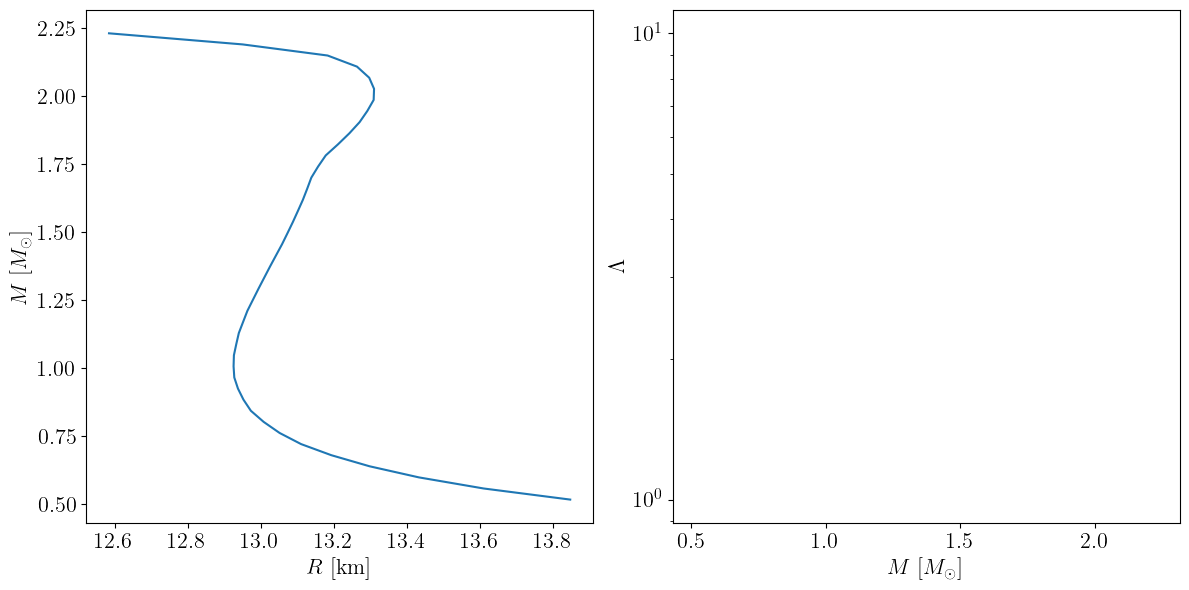

In [3]:
# Solve TOV equations:
beta_ST = -4.5
#initial guesses
phi_c = -0.1 
nu_c = -1.2
#Enter through EoS
eos_tuple = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple, ndat = 50, min_nsat = 1.0)
# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
m_min = 0.5
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, Lambdas)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

Solve the TOV equations for a single point in debug mode, to recover full details on the constructed solution

In [4]:
# Solve TOV equations:
beta_ST = -4.5
phi_c = -0.1
nu_c = -1.2
eos_tuple = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
logpc, masses, radii, Lambdas, sol_iter, sol_ext = construct_family_ST_sol(eos_tuple, ndat = 1, min_nsat = 3.0)

# Limit masses to be above certain mass to make plot prettier
m_min = 0.5
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# Check out first batch
r_vals_float   = sol_ext.ts[0]
M_vals_float   = sol_ext.ys[0][0]
nu_vals_float  = sol_ext.ys[1][0]
phi_vals_float = sol_ext.ys[2][0]
psi_vals_float = sol_ext.ys[3][0]

# r_vals_float   = jnp.array(r_vals/1e3).tolist()
# M_vals_float   = jnp.array(M_vals/utils.solar_mass_in_meter).tolist()
# nu_vals_float  = jnp.array(nu_vals).tolist()
# phi_vals_float = jnp.array(phi_vals).tolist()
# psi_vals_float = jnp.array(psi_vals).tolist()

Iteration 0: ν∞=0.03627866696243877, φ∞=-6.647196761369649e-05,νc=-1.229022933569951, φc=-0.09994682242590905, M=2.0251739598936815
Iteration 1: ν∞=0.00729587856505587, φ∞=-6.433684268926804e-05,νc=-1.2348596364219957, φc=-0.09989535295175764, M=2.025160626326784
Iteration 2: ν∞=0.0014990282148298459, φ∞=-6.218067673403131e-05,νc=-1.2360588589938595, φc=-0.0998456084103704, M=2.0251499653608627
Iteration 3: ν∞=0.00033884210444791256, φ∞=-6.004890081231086e-05,νc=-1.2363299326774178, φc=-0.09979756928972056, M=2.0251408927575225
Iteration 4: ν∞=0.00010595075372016967, φ∞=-5.794681847987257e-05,νc=-1.2364146932803939, φc=-0.09975121183493665, M=2.0251332535512074
Iteration 5: ν∞=5.899175320140792e-05, φ∞=-5.583307312497795e-05,νc=-1.236461886682955, φc=-0.09970654537643667, M=2.025128026064962
Iteration 6: ν∞=4.649758814537718e-05, φ∞=-5.3951895479771795e-05,νc=-1.2364990847534714, φc=-0.09966338386005286, M=2.025119356664204
Iteration 7: ν∞=4.1354793820129595e-05, φ∞=-5.2267821624643016

From the output of debug mode, we can plot the exterior solution:

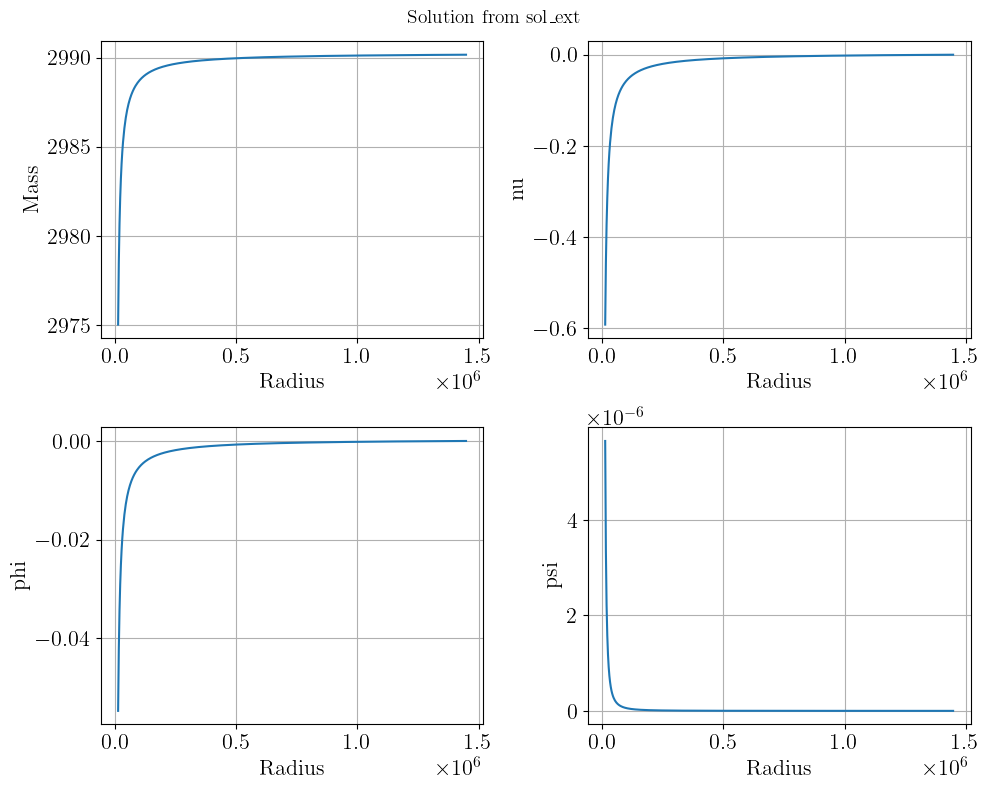

In [5]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Solution from sol_ext", fontsize=14)

# M vs r
axs[0, 0].plot(r_vals_float, M_vals_float)
axs[0, 0].set_xlabel("Radius")
axs[0, 0].set_ylabel("Mass")
axs[0, 0].grid(True)

# nu vs r
axs[0, 1].plot(r_vals_float, nu_vals_float)
axs[0, 1].set_xlabel("Radius")
axs[0, 1].set_ylabel("nu")
axs[0, 1].grid(True)

# phi vs r
axs[1, 0].plot(r_vals_float, phi_vals_float)
axs[1, 0].set_xlabel("Radius")
axs[1, 0].set_ylabel("phi")
axs[1, 0].grid(True)

# psi vs r
axs[1, 1].plot(r_vals_float, psi_vals_float)
axs[1, 1].set_xlabel("Radius")
axs[1, 1].set_ylabel("psi")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()



And combine them to see the full profile

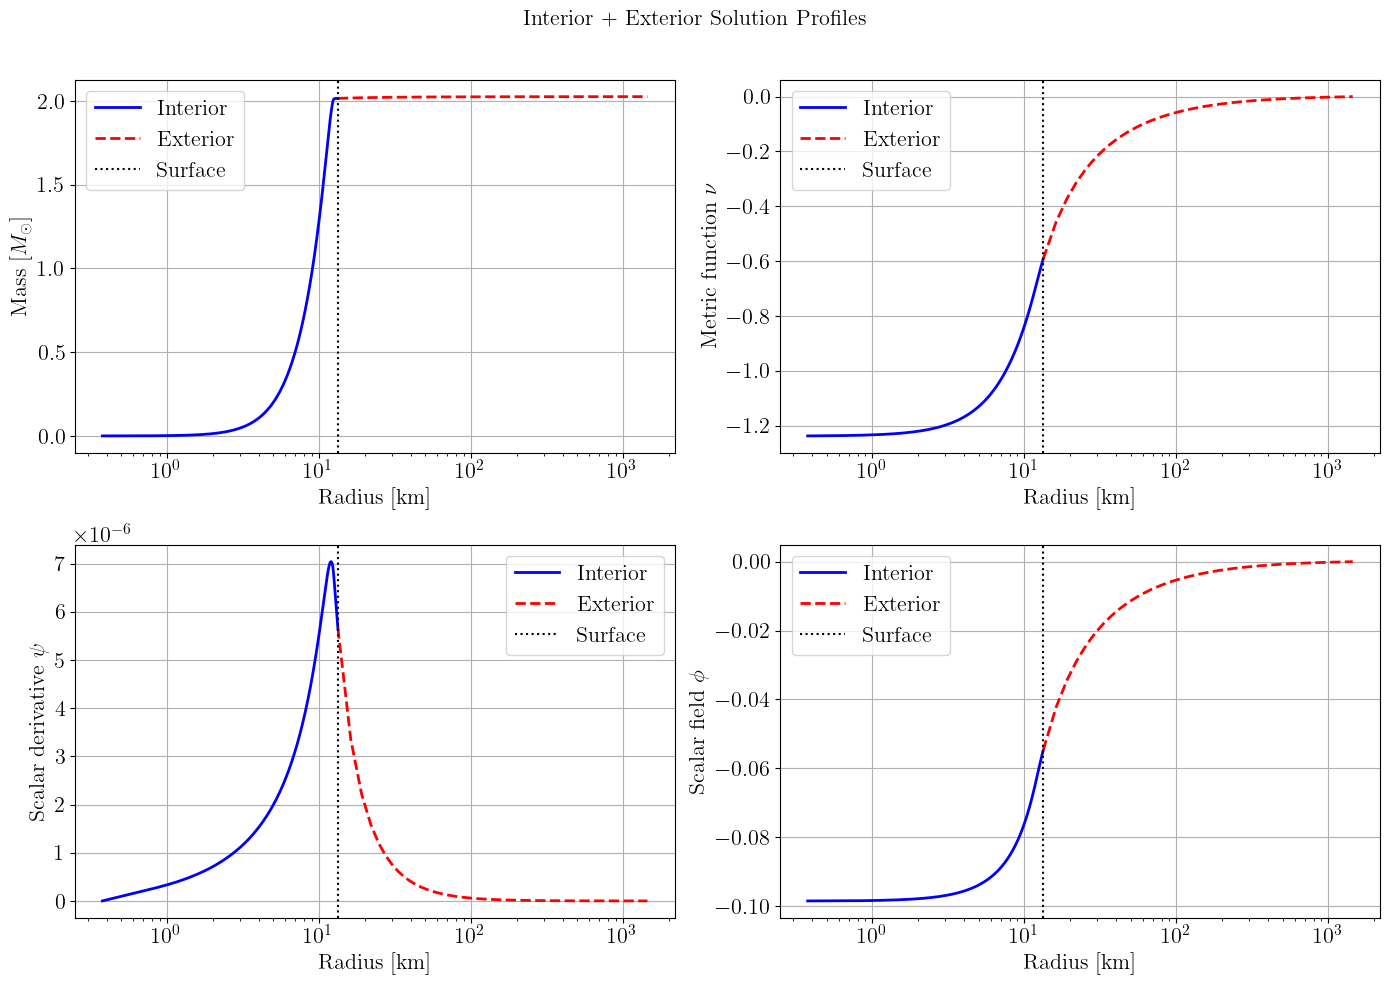

In [6]:
# Extract interior and exterior profiles
#y0 = (r0, m0, nu0_final, psi0, phi0_final)
r_int_m = sol_iter.ys[0][0]
M_int = sol_iter.ys[1][0]
nu_int = sol_iter.ys[2][0]
psi_int = sol_iter.ys[3][0]
phi_int = sol_iter.ys[4][0]
#y_surf = (M_s, nu_s, phi_s, psi_s)
r_ext_m = sol_ext.ts[0]
M_ext = sol_ext.ys[0][0]
nu_ext = sol_ext.ys[1][0]
phi_ext = sol_ext.ys[2][0]
psi_ext = sol_ext.ys[3][0]

# Convert to kilometers and solar masses
r_int = r_int_m / 1000
r_ext = r_ext_m / 1000
M_int_solar = M_int / utils.solar_mass_in_meter
M_ext_solar = M_ext / utils.solar_mass_in_meter

# Create composite plots with logarithmic x-axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Interior + Exterior Solution Profiles", fontsize=16)

# Mass Profile
axs[0, 0].semilogx(r_int, M_int_solar, 'b-', linewidth=2, label='Interior')
axs[0, 0].semilogx(r_ext, M_ext_solar, 'r--', linewidth=2, label='Exterior')
axs[0, 0].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[0, 0].set_xlabel("Radius [km]")
axs[0, 0].set_ylabel(r"Mass [$M_\odot$]")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Metric Function ν
axs[0, 1].semilogx(r_int, nu_int, 'b-', linewidth=2, label='Interior')
axs[0, 1].semilogx(r_ext, nu_ext, 'r--', linewidth=2, label='Exterior')
axs[0, 1].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[0, 1].set_xlabel("Radius [km]")
axs[0, 1].set_ylabel(r"Metric function $\nu$")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Scalar Derivative ψ
axs[1, 0].semilogx(r_int, psi_int, 'b-', linewidth=2, label='Interior')
axs[1, 0].semilogx(r_ext, psi_ext, 'r--', linewidth=2, label='Exterior')
axs[1, 0].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[1, 0].set_xlabel("Radius [km]")
axs[1, 0].set_ylabel(r"Scalar derivative $\psi$")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Scalar Field φ
axs[1, 1].semilogx(r_int, phi_int, 'b-', linewidth=2, label='Interior')
axs[1, 1].semilogx(r_ext, phi_ext, 'r--', linewidth=2, label='Exterior')
axs[1, 1].axvline(x=r_int[-1], color='k', linestyle=':', label='Surface')
axs[1, 1].set_xlabel("Radius [km]")
axs[1, 1].set_ylabel(r"Scalar field $\phi$")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Exploration of scalar-tensor effects

Below, we show the solutions for a sweep of the beta parameter space.

/var/folders/xj/6sk96vdn15385fpjn9nd1rcw0000gp/T/ipykernel_4538/1370823024.py:46: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


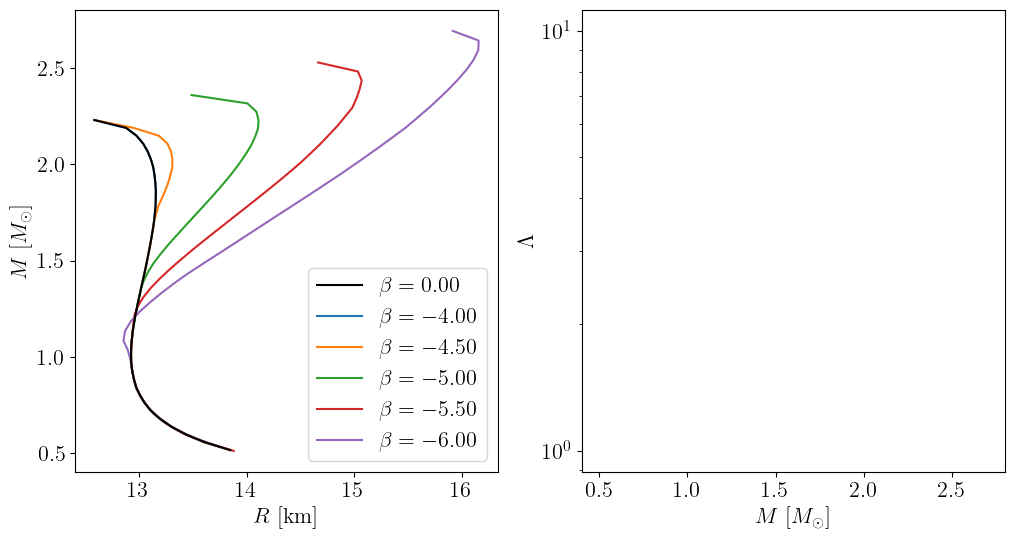

In [12]:
import numpy as np

# Solve TOV equations for multiple beta values:
beta_values = [0.0, -4.0, -4.5, -5, -5.5, -6]

# initial guess
phi_c = -0.1
nu_c = -1.2


plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, beta_ST in enumerate(beta_values):
    # Create EOS with current beta value
    eos_tuple = (ns, ps, hs, es, dloge_dlogps, beta_ST, phi_c, nu_c)
    logpc, masses, radii, Lambdas = construct_family_ST(eos_tuple, ndat=50, min_nsat=1.0)
    
    # Limit masses to be above certain mass
    m_min = 0.5
    mask = masses > m_min
    masses = masses[mask]
    radii = radii[mask]
    Lambdas = Lambdas[mask]
    if i == 0:
        c = "black"
        zorder=10
    else:
        c = None
        zorder=1
    
    # Plot M-R curve for this beta
    plt.subplot(121)
    plt.plot(radii, masses, label=rf'$\beta={beta_ST:.2f}$', color=c, zorder=zorder)
    
    plt.subplot(122)
    # Plot Lambda(M) curve
    plt.plot(masses, Lambdas, color=c, zorder=zorder)

plt.subplot(121)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")
plt.legend()

plt.subplot(122)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")

plt.show()
plt.close()